In [12]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import scipy
from numpy import mean, cov
from numpy.linalg import eigh
import math
import sys
import time
import seaborn as sns

%matplotlib inline

In [37]:
def plot_graph(k, labels, predicted_labels):
    hist = []
    for i in range(k):
        hist.append([])
    
    for i in range(len(labels)):
        hist[labels[i]].append(predicted_labels[i])

    plt.hist(hist)

In [38]:
def pca(data):
    cova = cov(data.T) 
    values, vectors = eigh(cova)
    idx = np.argsort(values)[::-1]
    values = np.real(values[idx])
    vectors = np.real(vectors.T[idx])
    return values, vectors

In [201]:
def kmeans(points, k, epochs=10000, centroids=None):
    begin = int(round(time.time() * 1000))
    last = begin
    not_finished = True
    if centroids is None:
        random_mask = np.random.choice(points.shape[0], k, replace=False)
        centroids = points[random_mask, :]
    epoch = 0
    labels = []
    
    while not_finished and epoch < epochs:
        labels = np.array([np.argmin([scipy.spatial.distance.euclidean(point, centroid) for centroid in centroids]) for point in points])
        not_finished = False

        for i in range(k):
            new_centroid = np.mean(points[np.where(labels == i)], axis=0)
            if not np.all(np.isclose(new_centroid, centroids[i])):
                centroids[i] = new_centroid
                not_finished = True

        if epoch != 0 == 0:
            current = int(round(time.time() * 1000))
            print('{} in {}ms. elapsed : {}ms.'.format(epoch, current - last, current - begin))
            last = current
        epoch = epoch + 1
        
    return labels, centroids


def kmeans_predict(centroids, points):
    return [np.argmin([scipy.spatial.distance.euclidean(point, centroid) for centroid in centroids]) for point in points]

1 in 6ms. elapsed : 6ms.


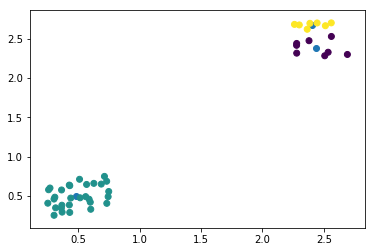

In [202]:
k = 3
points = []
for i in range(k):
    points.extend((np.random.rand(15, 2)) / 2 + (i - 1.5) * (i - 1.5))

points = np.array(points)
labels, centroids = kmeans(points, k)

plt.scatter(centroids[:, 0], centroids[:, 1])
plt.scatter(points[:, 0], points[:, 1], c=labels)

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_train = x_train.astype('float32') / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
x_test = x_test.astype('float32') / 255.0

Masks to select 0 and 1 labels.
Only train on 500 elements from 2 selected classes for prototyping purposes.

In [103]:
mask_0 = np.where(y_train == 0)
mask_1 = np.where(y_train == 1)

In [104]:
sub_x_train = np.concatenate((x_train[mask_0][:500], x_train[mask_1][:500]))
sub_y_train = np.concatenate((y_train[mask_0][:500], y_train[mask_1][:500]))

In [10]:
labels, centroids = kmeans(x_train, 11, epochs=100)

10
20
30
40


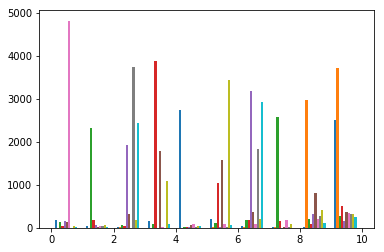

In [19]:
plot_graph(11, y_train, labels.astype('uint8'))

In [130]:
dims = 2
values, vectors = pca(x_train)
compressed_pca = x_train.dot(vectors[:dims].T)
compressed_pca.shape


(60000, 2)

In [128]:
labels, centroids = kmeans(compressed_pca, 10, epochs=100)

10
20
30
40
50
60
70


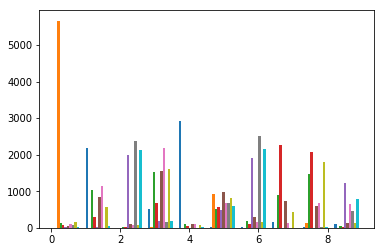

In [129]:
plot_graph(10, y_train, labels.astype('uint8'))

## Autoencoder

In [70]:
from keras.layers import Input, Dense
from keras.models import Model

In [71]:
x_train.shape

(60000, 784)

In [74]:
encoding_dim = 32  

input_img = Input(shape=(x_train.shape[1],))

encoded = Dense(encoding_dim, activation='relu')(input_img)

decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)


encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [95]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1040 - acc: 0.8134 - val_loss: 0.1022 - val_acc: 0.8125
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1037 - acc: 0.8134 - val_loss: 0.1019 - val_acc: 0.8126
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1034 - acc: 0.8134 - val_loss: 0.1016 - val_acc: 0.8126
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1031 - acc: 0.8135 - val_loss: 0.1014 - val_acc: 0.8126
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1029 - acc: 0.8135 - val_loss: 0.1011 - val_acc: 0.8126
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1026 - acc: 0.8135 - val_loss: 0.1009 - val_acc: 0.8127
Epoch 7/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1024 - acc: 0.8135 - val_loss: 0.1007 - val_acc

In [131]:
encoding_dim = 2  

dims = x_train.shape[1]
values, vectors = pca(x_train)
compressed_pca = x_train.dot(vectors[:dims].T)

input_img = Input(shape=(x_train.shape[1],))

encoded = Dense(encoding_dim, activation='relu')(input_img)

decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)


encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [132]:
compressed_pca.shape

(60000, 784)

In [133]:
autoencoder.fit(compressed_pca, compressed_pca,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0340 - acc: 0.0186 - val_loss: 0.5888 - val_acc: 0.8007
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: -0.2782 - acc: 0.0204 - val_loss: 0.5629 - val_acc: 0.8009
Epoch 3/50
60000/60000 [==============================] - 2s 28us/step - loss: -0.2881 - acc: 0.0204 - val_loss: 0.5495 - val_acc: 0.8012
Epoch 4/50
60000/60000 [==============================] - 2s 28us/step - loss: -0.2915 - acc: 0.0204 - val_loss: 0.5419 - val_acc: 0.8016
Epoch 5/50
60000/60000 [==============================] - 2s 31us/step - loss: -0.2935 - acc: 0.0204 - val_loss: 0.5370 - val_acc: 0.8019
Epoch 6/50
60000/60000 [==============================] - 2s 36us/step - loss: -0.2956 - acc: 0.0204 - val_loss: 0.5335 - val_acc: 0.8020
Epoch 7/50
60000/60000 [==============================] - 2s 33us/step - loss: -0.2991 - acc: 0.0204 - val_loss: 0.5306 - v

## Listings AirBnB

This dataset contains ~250k AirBnB listings with the property type as label a curated list of features.

The data prep has been done in a separate notebook.
Features have been selected according to our intuition and encoded in one hot vectors.

### PCA 2D

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [21]:
df_listings = pd.read_csv('embedded_listings.csv', sep=';')

In [22]:
df_listings

,Property Type,Accommodates,Bathrooms,Bedrooms,Beds,Room Type_Entire home/apt,Room Type_Private room,Room Type_Shared room,Bed Type_Airbed,Bed Type_Couch,...,Waterfront,Wheelchair Accessible,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower and toilet,Wide doorway,Wide hallway clearance,Window guards,Wireless Internet,Property Type Labels
0,Apartment,2.0,1.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Apartment,2.0,1.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Bed & Breakfast,2.0,2.0,1.0,2.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,Bed & Breakfast,1.0,1.5,1.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,Apartment,2.0,1.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,Apartment,4.0,2.0,2.0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,Serviced apartment,12.0,2.5,7.0,7.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,29
7,Condominium,2.0,1.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11
8,Apartment,2.0,1.0,1.0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,House,5.0,1.0,3.0,5.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,18


In [23]:
labels = ['Property Type']
encoded_labels = ['Property Type Labels']
df_features = df_listings.drop(columns=labels + encoded_labels)

In [222]:
values, vectors = pca(df_features)

In [26]:
dims = 2
compressed_pca = df_features.dot(vectors[:dims].T)

In [27]:
compressed_pca.loc[:, 'labels'] = df_listings[labels].values

In [28]:
compressed_pca

,0,1,labels
0,2.824708,1.306713,Apartment
1,2.806856,1.341699,Apartment
2,3.297086,2.733203,Bed & Breakfast
3,1.941257,2.614572,Bed & Breakfast
4,2.828188,2.897780,Apartment
5,5.312782,0.965708,Apartment
6,15.479468,-0.469430,Serviced apartment
7,2.913957,3.181689,Condominium
8,3.159152,0.002266,Apartment
9,7.900795,1.649043,House


In [29]:
compressed_pca = compressed_pca.rename(columns={0: 'x', 1:'y'})

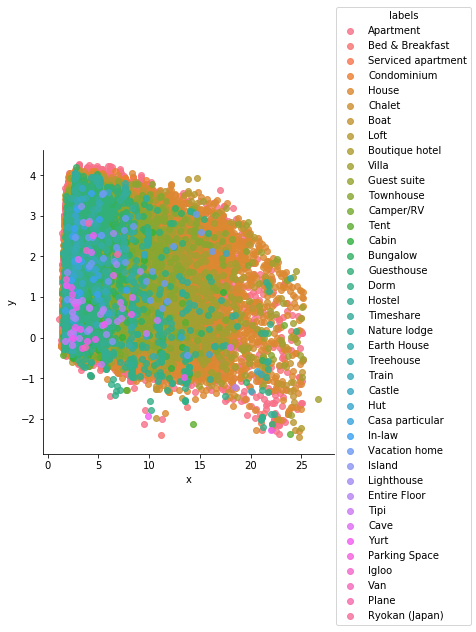

In [30]:
sns.lmplot(x='x', y='y', data=compressed_pca, hue='labels', fit_reg=False)

### Train/Test split

In [36]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_listings.loc[:, encoded_labels], test_size=0.3)

### K-means

In [221]:
labels, centroids = kmeans(x_train.as_matrix(), y_train.nunique().item(), epochs=10, centroids=x_train.iloc[np.random.choice(x_train.shape[0], y_train.nunique().item(), replace=False), :].as_matrix())

1 in 273428ms. elapsed : 273428ms.
2 in 133089ms. elapsed : 406517ms.
3 in 130623ms. elapsed : 537140ms.
4 in 133760ms. elapsed : 670900ms.
5 in 144918ms. elapsed : 815818ms.
6 in 140430ms. elapsed : 956248ms.
7 in 135110ms. elapsed : 1091358ms.
8 in 195923ms. elapsed : 1287281ms.
9 in 287389ms. elapsed : 1574670ms.


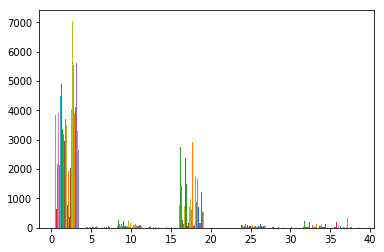

In [225]:
plot_graph(y_train.nunique().item(), labels, y_train.values)

### PCA into K-means

In [230]:
dims = 2
compressed_pca_train = x_train.dot(vectors[:dims].T)
compressed_pca_test = x_test.dot(vectors[:dims].T)

In [ ]:
labels, centroid = kmeans(compressed_pca_train.as_matrix(), y_train.nunique().item(), epochs=20)

1 in 190966ms. elapsed : 190966ms.
2 in 94468ms. elapsed : 285434ms.
3 in 97971ms. elapsed : 383405ms.


### Train/Test split autoencoder

In [ ]:
encoding_dim = 2

input_img = Input(shape=(x_train.shape[1],))

encoded = Dense(encoding_dim, activation='relu')(input_img)

decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)


encoded_input = Input(shape=(encoding_dim,))

decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [ ]:
autoencoder.fit(x_test.as_matrix(), x_test.as_matrix(),
                epochs=50,
                batch_size=256,
                shuffle=True)

In [ ]:
df_predict = y_test.join(df_listings[labels], how='inner')
predict = encoder.predict(x_test.as_matrix())
df_predict.loc[:, 'x'] = predict[:, 0]
df_predict.loc[:, 'y'] = predict[:, 1]

In [ ]:
sns.lmplot(x='x', y='y', data=df_predict, hue='Property Type', fit_reg=False) 

### Train/Test split PCA into 2D autoencoder

In [ ]:
dims = df_features.shape[1]
compressed_pca = x_train.dot(vectors[:dims].T)

In [226]:
compressed_pca

,x,y,labels
0,2.824708,1.306713,Apartment
1,2.806856,1.341699,Apartment
2,3.297086,2.733203,Bed & Breakfast
3,1.941257,2.614572,Bed & Breakfast
4,2.828188,2.897780,Apartment
5,5.312782,0.965708,Apartment
6,15.479468,-0.469430,Serviced apartment
7,2.913957,3.181689,Condominium
8,3.159152,0.002266,Apartment
9,7.900795,1.649043,House


In [ ]:
autoencoder.fit(compressed_pca.as_matrix(), compressed_pca.as_matrix(),
                epochs=50,
                batch_size=256,
                shuffle=True)

In [ ]:
dims = df_features.shape[1]
compressed_pca = x_test.dot(vectors[:dims].T)
df_predict = y_test.join(df_listings[labels], how='inner')
predict = encoder.predict(compressed_pca.as_matrix())
df_predict.loc[:, 'x'] = predict[:, 0]
df_predict.loc[:, 'y'] = predict[:, 1]

In [ ]:
sns.lmplot(x='x', y='y', data=df_predict, hue='Property Type', fit_reg=False) 